# Week 10: Analysis of Variance (ANOVA) (Interactive Lab)

**NOTE:** This notebook uses the exact example values from the lecture slides. Welcome to the Week 10 hands-on lab! In this exercise, you’ll explore One-Way ANOVA, assumption checks, and post-hoc tests in Python.


In [1]:
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
from statsmodels.stats.multicomp import pairwise_tukeyhsd
import statsmodels.api as sm
from statsmodels.formula.api import ols

np.random.seed(42)
plt.rcParams['figure.figsize'] = (8,4)

## Quick Concept Check 💡
1. What is the situation for an ANOVA test?
2. Why the name is Analysis of Variance although we compare means ?

## Blister Treatment Example

We are comparing **three treatments (A, B, P)** for how long blisters take to heal (in days).

| Treatment | Values |
|------------|---------|
| A | 5,6,6,7,7,8,9,10 |
| B | 7,7,8,9,9,10,10,11 |
| P | 7,9,9,10,10,10,11,12,13 |

We’ll calculate group means, grand mean, and ANOVA step-by-step.


**Question 1:** What is the null hypothesis for one-way ANOVA on the blister treatment data?

In [3]:
A = np.array([5,6,6,7,7,8,9,10])
B = np.array([7,7,8,9,9,10,10,11])
P = np.array([7,9,9,10,10,10,11,12,13])
groups = [A,B,P]
labels = ['A','B','P']

n_groups = [len(g) for g in groups]
means = [g.mean() for g in groups]
grand_mean = np.concatenate(groups).mean()

ssg = sum([n_groups[i]*(means[i]-grand_mean)**2 for i in range(3)])  # Between Groups
sse = sum([((groups[i]-means[i])**2).sum() for i in range(3)])       # Within Groups
sst = ssg + sse

k = 3
n_total = sum(n_groups)
df_between = k - 1
df_within = n_total - k
msg = ssg / df_between
mse = sse / df_within
F_obs = msg / mse
p_val = 1 - stats.f.cdf(F_obs, df_between, df_within)

print('Group means:', [round(m,3) for m in means])
print('Grand mean:', round(grand_mean,3))
print('SSG =', round(ssg,3), 'SSE =', round(sse,3), 'SST =', round(sst,3))
print('F =', round(F_obs,3), 'p-value =', round(p_val,5))

Group means: [7.25, 8.875, 10.111]
Grand mean: 8.8
SSG = 34.736 SSE = 59.264 SST = 94.0
F = 6.447 p-value = 0.00626


**Question 2:** What is the mean for Treatment B? (Round to 3 decimals)  

**Question 3:** What is the grand mean across all observations? (Round to 3 decimals)  

**Question 4:** What is the between-groups sum of squares (SSG)? (Round to 3 decimals)  

**Question 5:** What is the within-groups sum of squares (SSE)? (Round to 3 decimals)  

**Question 6:** What is the observed F-statistic? (Round to 3 decimals)  

**Question 7:** What are the degrees of freedom for numerator and for denominator for the F statistic? 

**Question 8:** What is the p-value for the ANOVA test? (Round to 3 decimals)


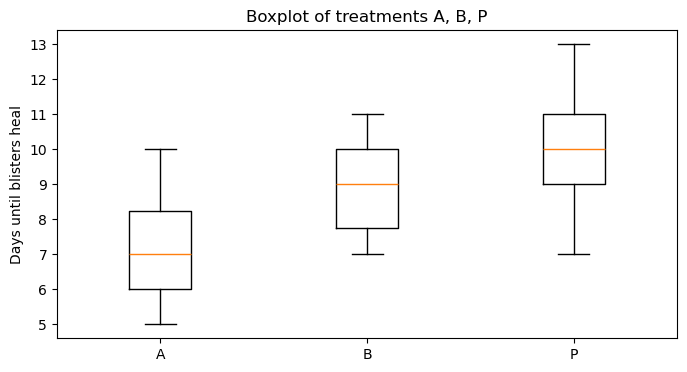

In [6]:
plt.boxplot(groups, labels=labels)
plt.title('Boxplot of treatments A, B, P')
plt.ylabel('Days until blisters heal')
plt.show()

Now, let’s confirm our manual results using Python’s built-in functions.

In [8]:
f_stat, p_scipy = stats.f_oneway(A,B,P)
print('scipy f_oneway:', f_stat, p_scipy)

df_stacked = pd.DataFrame({'value': np.concatenate(groups),
                           'group': np.repeat(labels, n_groups)})
model = ols('value ~ C(group)', data=df_stacked).fit()
from statsmodels.stats.anova import anova_lm
anova_lm(model)

scipy f_oneway: 6.447386922896648 0.0062558340721884315


,df,sum_sq,mean_sq,F,PR(>F)
C(group),2.0,34.736111,17.368056,6.447387,0.006256
Residual,22.0,59.263889,2.693813,NaN,NaN


## Checking ANOVA Assumptions

We’ll check **equal variances** and **normality**.

**Question 9:**  
Is the largest group SD less than twice the smallest group SD? So that the constant variance assumption met?


In [29]:
sds = [g.std(ddof=1) for g in groups]
print('Group SDs:', [round(s,3) for s in sds])

Group SDs: [1.669, 1.458, 1.764]


Let`s check normality. Do you think assumptions are met ?

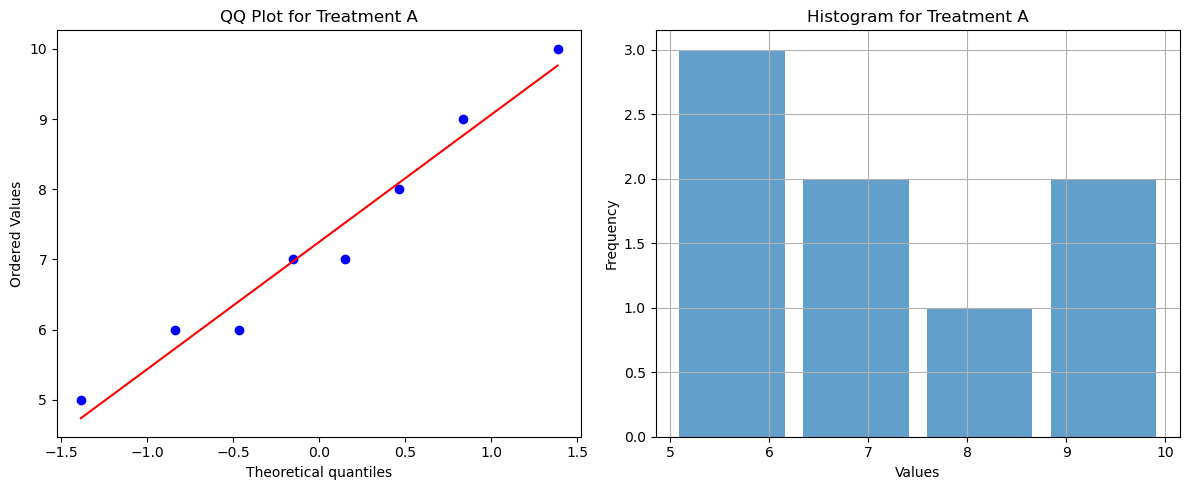

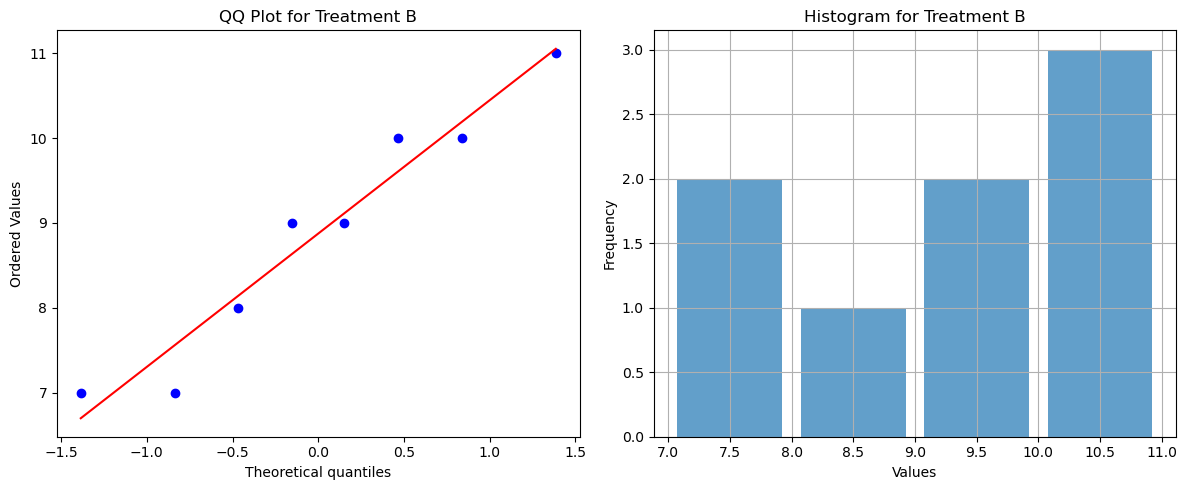

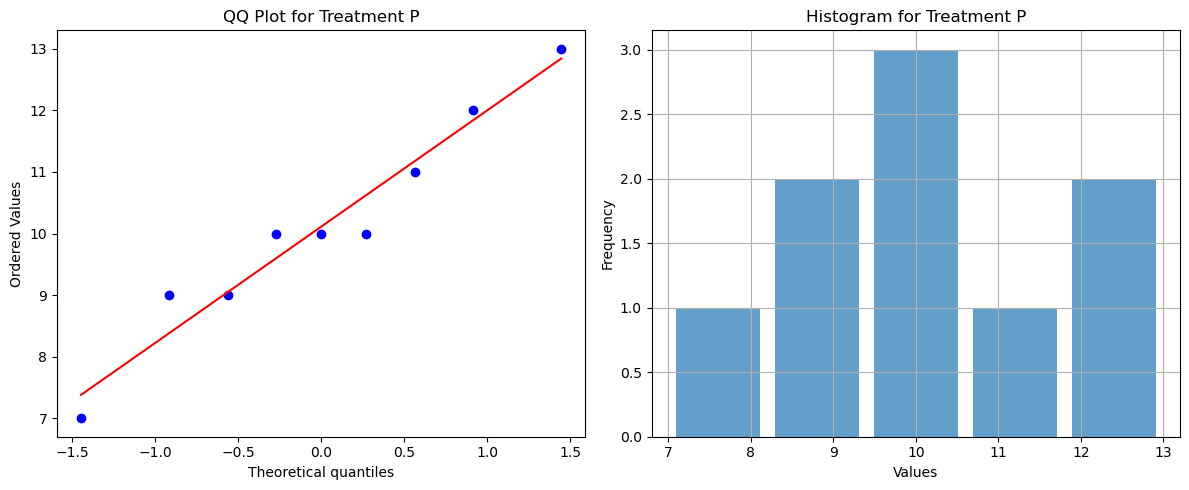

In [10]:
def plot_qq_hist(data, label):
    plt.figure(figsize=(12, 5))

    # QQ Plot
    plt.subplot(1, 2, 1)
    stats.probplot(data, dist="norm", plot=plt)
    plt.title(f'QQ Plot for {label}')

    # Histogram
    plt.subplot(1, 2, 2)
    plt.hist(data, bins="auto", alpha=0.7, rwidth=0.85)
    plt.title(f'Histogram for {label}')
    plt.xlabel('Values')
    plt.ylabel('Frequency')
    plt.grid(True)

    plt.tight_layout()
    plt.show()

# Plot for each treatment group
plot_qq_hist(A, 'Treatment A')
plot_qq_hist(B, 'Treatment B')
plot_qq_hist(P, 'Treatment P')

## Post-hoc Tests

We’ll now perform pairwise comparisons using **Tukey’s HSD** and **Bonferroni correction**.

**Question 10:**  
According to Tukey HSD (alpha=0.05), which pair shows a significant difference?  


Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj   lower  upper  reject
---------------------------------------------------
     A      B    1.625 0.1408 -0.4365 3.6865  False
     A      P   2.8611 0.0045  0.8577 4.8645   True
     B      P   1.2361  0.288 -0.7673 3.2395  False
---------------------------------------------------


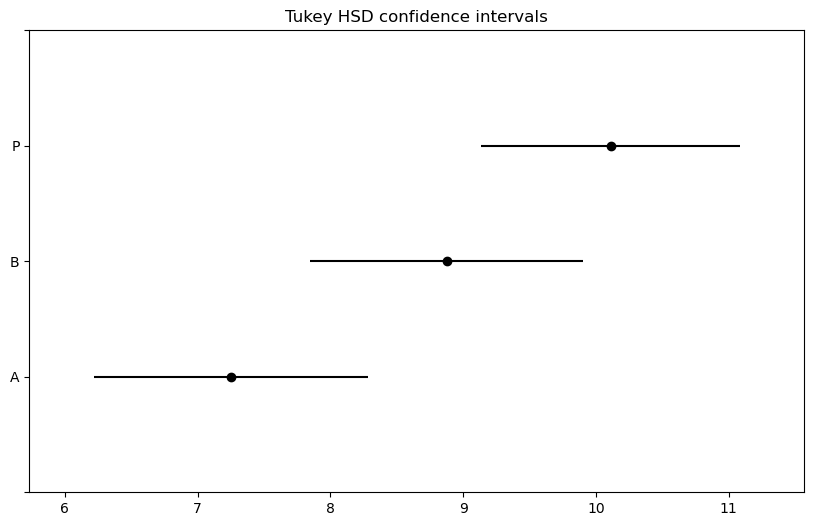

A vs B: t=-2.074, raw p=0.05700, Bonferroni adj p=0.17099
A vs P: t=-3.423, raw p=0.00378, Bonferroni adj p=0.01133
B vs P: t=-1.562, raw p=0.13903, Bonferroni adj p=0.41710


In [12]:
res = pairwise_tukeyhsd(endog=df_stacked['value'],
                        groups=df_stacked['group'], alpha=0.05)
print(res)
res.plot_simultaneous()
plt.title('Tukey HSD confidence intervals')
plt.show()

from itertools import combinations
pairs = list(combinations(range(3), 2))
for i,j in pairs:
    tstat, pval_pair = stats.ttest_ind(groups[i], groups[j], equal_var=True)
    p_adj = min(pval_pair * 3, 1.0)
    print(f"{labels[i]} vs {labels[j]}: t={tstat:.3f}, raw p={pval_pair:.5f}, Bonferroni adj p={p_adj:.5f}")


## Simulation Demo: F under Equal vs Different Means

Now let’s simulate two scenarios:
- Groups with **equal means** (null true)
- Groups with **different means** (null false)

Run the code and observe how the F distribution changes.

**Question 11:**  
Which scenario produces a larger average F? Why does that align with ANOVA intuition?


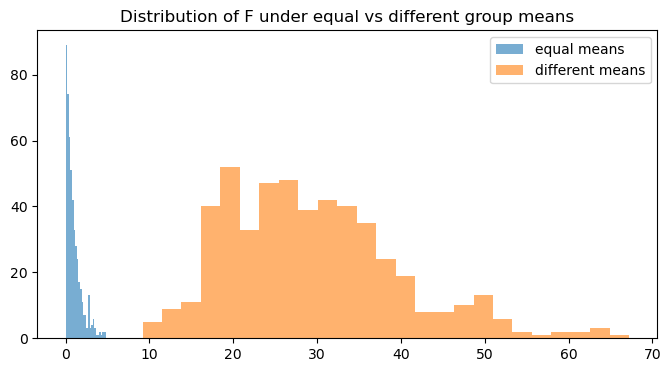

Mean F (equal): 0.943
Mean F (different): 29.422


In [14]:
def sim_F(means_sim, n_per_group=15, trials=500):
    Fs = []
    for _ in range(trials):
        groups_sim = [np.random.normal(loc=m, scale=1.5, size=n_per_group) for m in means_sim]
        grand = np.concatenate(groups_sim).mean()
        ssg_sim = sum([len(groups_sim[i])*(groups_sim[i].mean()-grand)**2 for i in range(len(groups_sim))])
        sse_sim = sum([((groups_sim[i]-groups_sim[i].mean())**2).sum() for i in range(len(groups_sim))])
        msg_sim = ssg_sim/(len(groups_sim)-1)
        mse_sim = sse_sim/(len(np.concatenate(groups_sim))-len(groups_sim))
        Fs.append(msg_sim/mse_sim)
    return np.array(Fs)

Fs_equal = sim_F([5,5,5], n_per_group=15, trials=500)
Fs_diff = sim_F([5,7,9], n_per_group=15, trials=500)

plt.hist(Fs_equal, bins=25, alpha=0.6, label='equal means')
plt.hist(Fs_diff, bins=25, alpha=0.6, label='different means')
plt.legend()
plt.title('Distribution of F under equal vs different group means')
plt.show()

print('Mean F (equal):', round(Fs_equal.mean(),3))
print('Mean F (different):', round(Fs_diff.mean(),3))


**Question 12:** From the Scheffe intervals below, confidence interval for which pair does not involve zero?

In [16]:
# --- Scheffé method for confidence intervals ---
alpha = 0.05
scheffe_critical_value = np.sqrt((k - 1) * stats.f.ppf(1 - alpha, k - 1, df_within))

# Pairwise comparisons and standard errors
mean_diffs = {
    ('A', 'B'): means[0] - means[1],
    ('A', 'P'): means[0] - means[2],
    ('B', 'P'): means[1] - means[2]
}
se_diffs = {
    ('A', 'B'): np.sqrt(mse * (1/n_groups[0] + 1/n_groups[1])),
    ('A', 'P'): np.sqrt(mse * (1/n_groups[0] + 1/n_groups[2])),
    ('B', 'P'): np.sqrt(mse * (1/n_groups[1] + 1/n_groups[2]))
}

# --- Confidence intervals ---
ci_intervals = {
    comparison: (diff - scheffe_critical_value * se, diff + scheffe_critical_value * se)
    for comparison, diff in mean_diffs.items()
    for se in [se_diffs[comparison]]
}

print("\nScheffé confidence intervals:")
for comparison, ci in ci_intervals.items():
    print(f"{comparison}: {tuple(round(x,3) for x in ci)}")


Scheffé confidence intervals:
('A', 'B'): (-3.779, 0.529)
('A', 'P'): (-4.954, -0.768)
('B', 'P'): (-3.329, 0.857)


## Wrap-Up & Reflection

- What does a large F-statistic indicate?  
- How is ANOVA related to t-tests?  
- When should post-hoc tests be used?

**Submit:** Complete your Blackboard Quiz before midnight.  
You may keep this notebook for your notes and future reference.
